# First order ODE:

\begin{equation}
    \frac{dy}{dx} + p(x)\cdot y = f(x)
\end{equation}

\begin{equation}
    x \; \in \; [0, 1]
\end{equation}

\begin{equation}
    y(0) = A
\end{equation}

# Solving ODE:

Finding the solution for the differential equation is the same as minimizing loss function ($min\{\mathcal{L} \}$), where the loss function is defined as:

\begin{equation}
    \mathcal{L} = \int_0^1 \left(\frac{d y}{dx} - f(x)\right)^2 dx
\end{equation}

# Neural Networks

\begin{equation}
    y \approx \mathcal{N}(x)
\end{equation}

Loss function:

\begin{equation}   
    MSE = MSE_f + MSE_u
\end{equation}

where

\begin{equation}
    MSE_f = \frac{1}{N_f} \sum_{i=1}^{N_f} (\frac{d \mathcal{N}(x)}{dx}|_{x = x_i} - f(x_i))^2
\end{equation}

and

\begin{equation}
    MSE_u = \frac{1}{N_u} \sum_{i=1}^{N_u} (\mathcal{N}(x_i) - y(x_i))^2
\end{equation}


## Building Neural Network

In [14]:
import torch
import torch.nn as nn
import numpy as np
# check if GPU is available and use it; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
device

device(type='cuda', index=0)

In [3]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer = nn.Linear(1, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        layer_out = torch.sigmoid(self.hidden_layer(x))
        output = self.output_layer(layer_out)
        return output

#N = nn.Sequential(nn.Linear(1, 10), nn.Sigmoid(), nn.Linear(10, 1))

In [4]:
N = Network()
N = N.to(device)

## Example Function and BC

\begin{equation}
    \begin{cases}
      f(x) = e^x\\
      p(x) = 0
    \end{cases}\,.
\end{equation}

\begin{equation}
    y(0) = 1
\end{equation}


### Exact Solution

\begin{equation}
    y = e^x
\end{equation}

In [5]:
def f(x):
    return torch.exp(x)

def loss(x):
    x.requires_grad = True
    y = N(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]

    return torch.mean( (dy_dx - f(x))**2 ) + (y[0, 0] - 1.)**2

In [7]:
optimizer = torch.optim.LBFGS(N.parameters())

x = torch.linspace(0, 1, 100)[:, None].to(device)

def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()

    return l

epochs = 10
for i in range(epochs):
    optimizer.step(closure)


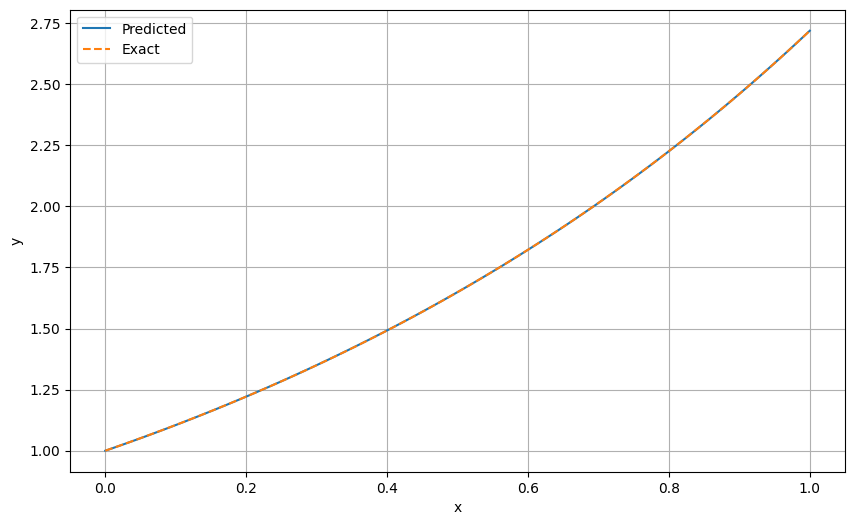

In [15]:
import matplotlib.pyplot as plt

xx = torch.linspace(0, 1, 100)[:, None].to(device)
with torch.no_grad():
    yy = N(xx)

xx = xx.cpu().numpy()
yy = yy.cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(xx, yy, label="Predicted")
plt.plot(xx, np.exp(xx), '--', label="Exact")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()

# Second order ODE:

\begin{equation}
    \frac{d^2 y}{dx^2} + p(x) \frac{dy}{dx} + q(x) y = f(x)
\end{equation}

\begin{equation}
    x \; \in \; [0, 1]
\end{equation}

\begin{equation}
    y(0) = A
\end{equation}

\begin{equation}
    y(1) = B
\end{equation}

## Example Function and BC

\begin{equation}
    \begin{cases}
      p(x) = 0\\
      q(x) = 0\\
      f(x) = -1
    \end{cases}\,.
\end{equation}

\begin{equation}
    \begin{cases}
      y(0) = 0\\
      y(1) = 0
    \end{cases}\,.
\end{equation}

### Exact Solution

\begin{equation}
    y(x) = - \frac{1}{2}x^2 + \frac{1}{2}x
\end{equation}

In [16]:
class Network2(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer = nn.Linear(1, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        layer_out = torch.sigmoid(self.hidden_layer(x))
        output = self.output_layer(layer_out)
        return output

N2 = Network2()
N2 = N2.to(device)

In [17]:
def f(x):
    return -torch.ones(x.shape[0], x.shape[1])

def loss(x):
    x.requires_grad = True
    y = N2(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    y_double_prime = torch.autograd.grad(dy_dx.sum(), x, create_graph=True)[0]

    return torch.mean( (y_double_prime - f(x))**2 ) + 0.5*(y[0, 0] - 0.)**2 + 0.5*(y[-1, 0] - 0.)**2

In [20]:
optimizer = torch.optim.LBFGS(N2.parameters())

x = torch.linspace(0, 1, 100)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()

    return l

epochs = 10
for i in range(epochs):
    optimizer.step(closure)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

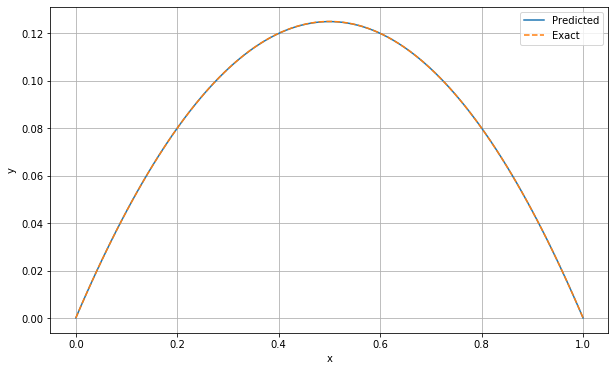

In [ ]:
import matplotlib.pyplot as plt

xx = torch.linspace(0, 1, 100)[:, None]
with torch.no_grad():
    yy = N2(xx)

plt.figure(figsize=(10, 6))
plt.plot(xx, yy, label="Predicted")
plt.plot(xx, -0.5*torch.pow(xx, 2) + 0.5*xx, '--', label="Exact")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()

Sources: https://www.sciencedirect.com/science/article/pii/S0021999118307125